In [1]:
import sys
sys.path.append('./src')
import json
import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from backbones import OGBEmbedCINpp
from utils import get_data_loaders, set_seed, init_metric_dict, update_and_save_best_epoch_res, ExtractorMLP, get_optimizer, load_checkpoint
from trainer import run_one_epoch, get_viz_idx, visualize_results
from datetime import datetime
from torch.nn import functional as F
from baselines import LRIBern


/home/godfrey/anaconda3/envs/topo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using /home/godfrey/.cache/torch_extensions/py310_cu116 as PyTorch extensions root...
Emitting ninja build file /home/godfrey/.cache/torch_extensions/py310_cu116/pershom_cuda_ext/build.ninja...
Building extension module pershom_cuda_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module pershom_cuda_ext...


In [2]:
# dataset_name = 'ba_2motifs'
dataset_name = 'ba_house_or_grid'
# dataset_name = 'spmotif_0.5'
# dataset_name = 'mutag'
# dataset_name = 'ogbg_molhiv'
model_name = 'cinpp'

method_name = 'lri_bern'
cuda_id = 1
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

model_config = {'num_layers': 3, 'emb_dim': 64, 'nonlinearity': 'relu', 'drop_rate': 0.3, 'readout': 'sum', 'final_readout':'sum', 'drop_position':'lin2',
                'graph_norm':'bn', 'atom_encoder':False}   
data_config = {'data_name': dataset_name, 'data_dir': '../data', 'max_ring_size': 5, 'include_down_adj': True, 'init_method': 'sum', 'n_jobs': 32}

method_config = {
    "one_encoder": True,
    "attn_constraint": "none",
    "temperature": 1.0,
    "decay_interval": 10,
    "decay_r": 0.1,
    "init_r": 0.7,
    "pred_loss_coef": 1.0,
    "pred_lr": 1.0e-3,
    "pred_wd": 1.0e-5,
    "dropout_p": 0.2,
    "norm_type": "batch",
    "act_type": "relu",
    'info_loss_coef': 0.1,
    'final_r': 0.7
}

optimizer_config = {
    "batch_size": 128,
    "wp_lr": 1.0e-3,
    "wp_wd": 1.0e-5,
    "attn_lr": 1.0e-3,
    "attn_wd": 1.0e-5,
    "emb_lr": 1.0e-3,
    "emb_wd": 1.0e-5
}

    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, dataset, test_set, x_dim, edge_attr_dim = get_data_loaders(dataset_name, batch_size=128, data_config=data_config)
# model_config['deg'] = aux_info['deg']

Processing...
/home/godfrey/anaconda3/envs/topo/lib/python3.10/site-packages/torch_geometric/utils/convert.py:250: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_new.cpp:230.)
  data[key] = torch.tensor(value)


[INFO] Split dataset!
Converting the ba_house_or_grid dataset to a cell complex...


100%|██████████| 2000/2000 [00:12<00:00, 154.31it/s]


Saving processed dataset in ../data/ba_house_or_grid/cell_complex_dim2_sum_5rings-E/ba_house_or_grid_complex.pt...
Saving idx in ../data/ba_house_or_grid/cell_complex_dim2_sum_5rings-E/ba_house_or_grid_idx.pt...
Loading dataset from disk...


Done!


In [5]:
clf = OGBEmbedCINpp(x_dim,
                    edge_attr_dim,
                    1,                       # out_size
                    model_config['num_layers'],                         # num_layers
                    model_config['emb_dim'],                            # hidden
                    dropout_rate=model_config['drop_rate'],             # dropout_rate
                    indropout_rate=0.0,         # in-dropout_rate
                    max_dim=2,                 # max_dim
                    jump_mode=None,                # jump_mode
                    nonlinearity=model_config['nonlinearity'],          # nonlinearity
                    readout=model_config['readout'],                    # readout
                    final_readout=model_config['final_readout'],        # final readout
                    apply_dropout_before=model_config['drop_position'], # where to apply dropout
                    use_coboundaries=True,       # whether to use coboundaries
                    embed_edge=True,       # whether to use edge feats
                    graph_norm=model_config['graph_norm'],              # normalization layer
                    readout_dims=(0, 1),              # readout_dims
                    atom_encoder=model_config["atom_encoder"]
                    ).to(device)

extractor = ExtractorMLP(model_config['emb_dim'], method_config)
extractor = extractor.to(device)
criterion = F.binary_cross_entropy_with_logits
baseline = LRIBern(clf, extractor, criterion, method_config)
optimizer = get_optimizer(clf, extractor, optimizer_config, method_config, warmup=False, slayer=baseline.readout, gaus=baseline.gaus)

In [6]:
warmup = 0
writer = None
topk = 1
report_dict = None
for epoch in range(20):
    train_res = run_one_epoch(baseline, optimizer, loaders['train'], epoch, 'train', warmup, seed, device, writer, method_name)
    valid_res = run_one_epoch(baseline, None, loaders['valid'], epoch, 'valid', warmup, seed, device, writer, method_name)
    test_res = run_one_epoch(baseline, None, loaders['test'], epoch, 'test', warmup, seed, device, writer, method_name)
    
    metric_dict = update_and_save_best_epoch_res(baseline, train_res, valid_res, test_res, metric_dict, epoch, model_dir, seed, topk, False, writer)
    report_dict = {k.replace('metric/best_', ''): v for k, v in metric_dict.items()}  # for better readability
print(json.dumps(report_dict, indent=4))

[Seed 0, Epoch: 0]: train done, loss: -1.134, pred: 0.989, v_info: 0.000, gas: 0.488, c_info: 0.000, tpl: -217.115, org_acc: 0.556, msk_acc: 0.526, org_auc: 0.590, msk_auc: 0.578, exp_auc: 0.498, bkg_attn: 0.532, sig_attn: 0.531, : 100%|██████████| 13/13 [00:35<00:00,  2.76s/it]
[Seed 0, Epoch: 0]: valid done, loss: -0.695, pred: 0.880, v_info: 0.000, gas: 0.439, c_info: 0.000, tpl: -161.868, org_acc: 0.485, msk_acc: 0.520, org_auc: 0.627, msk_auc: 0.983, exp_auc: 0.335, bkg_attn: 0.305, sig_attn: 0.230, : 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
[Seed 0, Epoch: 0]: test  done, loss: -0.510, pred: 0.954, v_info: 0.000, gas: 0.447, c_info: 0.000, tpl: -150.871, org_acc: 0.450, msk_acc: 0.480, org_auc: 0.603, msk_auc: 0.975, exp_auc: 0.294, bkg_attn: 0.295, sig_attn: 0.213, : 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred Loss: 0.880, Best Val Pred AUROC: 0.335, Best Test Pred AUROC: 0.294, Best Test X AUROC: 0.975, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 1]: train done, loss: -3.263, pred: 0.732, v_info: 0.000, gas: 0.487, c_info: 0.000, tpl: -404.425, org_acc: 0.618, msk_acc: 0.604, org_auc: 0.720, msk_auc: 0.678, exp_auc: 0.482, bkg_attn: 0.549, sig_attn: 0.532, : 100%|██████████| 13/13 [00:35<00:00,  2.71s/it]
[Seed 0, Epoch: 1]: valid done, loss: -3.331, pred: 1.043, v_info: 0.000, gas: 0.453, c_info: 0.000, tpl: -441.889, org_acc: 0.545, msk_acc: 0.470, org_auc: 0.618, msk_auc: 0.305, exp_auc: 0.109, bkg_attn: 0.683, sig_attn: 0.385, : 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
[Seed 0, Epoch: 1]: test  done, loss: -3.235, pred: 1.012, v_info: 0.000, gas: 0.454, c_info: 0.000, tpl: -429.292, org_acc: 0.575, msk_acc: 0.520, org_auc: 0.673, msk_auc: 0.205, exp_auc: 0.095, bkg_attn: 0.678, sig_attn: 0.363, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred Loss: 0.880, Best Val Pred AUROC: 0.335, Best Test Pred AUROC: 0.294, Best Test X AUROC: 0.975, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 2]: train done, loss: -4.397, pred: 0.506, v_info: 0.000, gas: 0.487, c_info: 0.000, tpl: -495.156, org_acc: 0.770, msk_acc: 0.746, org_auc: 0.861, msk_auc: 0.838, exp_auc: 0.522, bkg_attn: 0.562, sig_attn: 0.584, : 100%|██████████| 13/13 [00:34<00:00,  2.68s/it]
[Seed 0, Epoch: 2]: valid done, loss: 48.612, pred: 50.318, v_info: 0.000, gas: 0.692, c_info: 0.000, tpl: -177.530, org_acc: 0.480, msk_acc: 0.480, org_auc: 0.205, msk_auc: 0.000, exp_auc: 0.166, bkg_attn: 0.975, sig_attn: 0.938, : 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]
[Seed 0, Epoch: 2]: test  done, loss: 44.542, pred: 46.142, v_info: 0.000, gas: 0.691, c_info: 0.000, tpl: -166.921, org_acc: 0.525, msk_acc: 0.525, org_auc: 0.159, msk_auc: 0.000, exp_auc: 0.168, bkg_attn: 0.973, sig_attn: 0.939, : 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred Loss: 0.880, Best Val Pred AUROC: 0.335, Best Test Pred AUROC: 0.294, Best Test X AUROC: 0.975, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 3]: train done, loss: -5.403, pred: 0.169, v_info: 0.000, gas: 0.489, c_info: 0.000, tpl: -562.094, org_acc: 0.932, msk_acc: 0.943, org_auc: 0.983, msk_auc: 0.980, exp_auc: 0.661, bkg_attn: 0.546, sig_attn: 0.705, : 100%|██████████| 13/13 [00:35<00:00,  2.70s/it]
[Seed 0, Epoch: 3]: valid done, loss: 26.665, pred: 30.926, v_info: 0.000, gas: 0.665, c_info: 0.000, tpl: -432.713, org_acc: 0.480, msk_acc: 0.480, org_auc: 0.049, msk_auc: 0.058, exp_auc: 0.189, bkg_attn: 0.955, sig_attn: 0.909, : 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
[Seed 0, Epoch: 3]: test  done, loss: 24.321, pred: 28.402, v_info: 0.000, gas: 0.667, c_info: 0.000, tpl: -414.753, org_acc: 0.525, msk_acc: 0.525, org_auc: 0.035, msk_auc: 0.032, exp_auc: 0.188, bkg_attn: 0.956, sig_attn: 0.911, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred Loss: 0.880, Best Val Pred AUROC: 0.335, Best Test Pred AUROC: 0.294, Best Test X AUROC: 0.975, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 4]: train done, loss: -7.478, pred: 0.071, v_info: 0.000, gas: 0.490, c_info: 0.000, tpl: -759.838, org_acc: 0.968, msk_acc: 0.980, org_auc: 0.993, msk_auc: 0.995, exp_auc: 0.723, bkg_attn: 0.543, sig_attn: 0.762, : 100%|██████████| 13/13 [00:34<00:00,  2.63s/it]
[Seed 0, Epoch: 4]: valid done, loss: 5.555, pred: 11.211, v_info: 0.000, gas: 0.485, c_info: 0.000, tpl: -570.437, org_acc: 0.485, msk_acc: 0.480, org_auc: 0.228, msk_auc: 0.147, exp_auc: 0.289, bkg_attn: 0.772, sig_attn: 0.655, : 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
[Seed 0, Epoch: 4]: test  done, loss: 4.906, pred: 10.085, v_info: 0.000, gas: 0.486, c_info: 0.000, tpl: -522.755, org_acc: 0.525, msk_acc: 0.525, org_auc: 0.189, msk_auc: 0.120, exp_auc: 0.284, bkg_attn: 0.772, sig_attn: 0.652, : 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


[Seed 0, Epoch: 4]: Best Epoch: 0, Best Val Pred Loss: 0.880, Best Val Pred AUROC: 0.335, Best Test Pred AUROC: 0.294, Best Test X AUROC: 0.975, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 5]: train done, loss: -9.054, pred: 0.059, v_info: 0.000, gas: 0.492, c_info: 0.000, tpl: -916.252, org_acc: 0.991, msk_acc: 0.985, org_auc: 0.999, msk_auc: 0.996, exp_auc: 0.761, bkg_attn: 0.545, sig_attn: 0.799, : 100%|██████████| 13/13 [00:34<00:00,  2.68s/it]
[Seed 0, Epoch: 5]: valid done, loss: 1.445, pred: 9.220, v_info: 0.000, gas: 0.436, c_info: 0.000, tpl: -781.883, org_acc: 0.480, msk_acc: 0.480, org_auc: 0.199, msk_auc: 0.102, exp_auc: 0.450, bkg_attn: 0.370, sig_attn: 0.311, : 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
[Seed 0, Epoch: 5]: test  done, loss: 1.107, pred: 8.332, v_info: 0.000, gas: 0.411, c_info: 0.000, tpl: -726.581, org_acc: 0.525, msk_acc: 0.525, org_auc: 0.131, msk_auc: 0.062, exp_auc: 0.471, bkg_attn: 0.386, sig_attn: 0.339, : 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Seed 0, Epoch: 5]: Best Epoch: 5, Best Val Pred Loss: 9.220, Best Val Pred AUROC: 0.450, Best Test Pred AUROC: 0.471, Best Test X AUROC: 0.062, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 6]: train done, loss: -9.944, pred: 0.046, v_info: 0.000, gas: 0.492, c_info: 0.000, tpl: -1003.915, org_acc: 0.971, msk_acc: 0.987, org_auc: 0.998, msk_auc: 0.998, exp_auc: 0.793, bkg_attn: 0.545, sig_attn: 0.827, : 100%|██████████| 13/13 [00:34<00:00,  2.67s/it]
[Seed 0, Epoch: 6]: valid done, loss: -0.328, pred: 7.505, v_info: 0.000, gas: 0.438, c_info: 0.000, tpl: -787.673, org_acc: 0.480, msk_acc: 0.480, org_auc: 0.371, msk_auc: 0.026, exp_auc: 0.195, bkg_attn: 0.537, sig_attn: 0.265, : 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]
[Seed 0, Epoch: 6]: test  done, loss: -0.373, pred: 6.781, v_info: 0.000, gas: 0.462, c_info: 0.000, tpl: -720.016, org_acc: 0.525, msk_acc: 0.525, org_auc: 0.316, msk_auc: 0.019, exp_auc: 0.197, bkg_attn: 0.481, sig_attn: 0.188, : 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


[Seed 0, Epoch: 6]: Best Epoch: 5, Best Val Pred Loss: 9.220, Best Val Pred AUROC: 0.450, Best Test Pred AUROC: 0.471, Best Test X AUROC: 0.062, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 7]: train done, loss: -10.655, pred: 0.044, v_info: 0.000, gas: 0.487, c_info: 0.000, tpl: -1074.769, org_acc: 0.972, msk_acc: 0.990, org_auc: 0.998, msk_auc: 0.999, exp_auc: 0.774, bkg_attn: 0.548, sig_attn: 0.811, : 100%|██████████| 13/13 [00:35<00:00,  2.73s/it]
[Seed 0, Epoch: 7]: valid done, loss: -5.657, pred: 0.649, v_info: 0.000, gas: 0.474, c_info: 0.000, tpl: -635.322, org_acc: 1.000, msk_acc: 0.835, org_auc: 1.000, msk_auc: 0.976, exp_auc: 0.975, bkg_attn: 0.323, sig_attn: 0.862, : 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
[Seed 0, Epoch: 7]: test  done, loss: -5.378, pred: 0.465, v_info: 0.000, gas: 0.445, c_info: 0.000, tpl: -588.744, org_acc: 1.000, msk_acc: 0.845, org_auc: 1.000, msk_auc: 0.988, exp_auc: 0.979, bkg_attn: 0.363, sig_attn: 0.868, : 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Seed 0, Epoch: 7]: Best Epoch: 7, Best Val Pred Loss: 0.649, Best Val Pred AUROC: 0.975, Best Test Pred AUROC: 0.979, Best Test X AUROC: 0.988, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 8]: train done, loss: -10.866, pred: 0.096, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -1101.008, org_acc: 0.961, msk_acc: 0.971, org_auc: 0.994, msk_auc: 0.994, exp_auc: 0.763, bkg_attn: 0.548, sig_attn: 0.802, : 100%|██████████| 13/13 [00:36<00:00,  2.85s/it]
[Seed 0, Epoch: 8]: valid done, loss: -7.315, pred: 0.008, v_info: 0.000, gas: 0.472, c_info: 0.000, tpl: -737.028, org_acc: 0.995, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 0.981, bkg_attn: 0.317, sig_attn: 0.875, : 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
[Seed 0, Epoch: 8]: test  done, loss: -6.610, pred: 0.010, v_info: 0.000, gas: 0.477, c_info: 0.000, tpl: -666.718, org_acc: 1.000, msk_acc: 0.995, org_auc: 1.000, msk_auc: 1.000, exp_auc: 0.983, bkg_attn: 0.304, sig_attn: 0.887, : 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[Seed 0, Epoch: 8]: Best Epoch: 8, Best Val Pred Loss: 0.008, Best Val Pred AUROC: 0.981, Best Test Pred AUROC: 0.983, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 9]: train done, loss: -12.122, pred: 0.068, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -1223.859, org_acc: 0.978, msk_acc: 0.981, org_auc: 0.999, msk_auc: 0.997, exp_auc: 0.790, bkg_attn: 0.542, sig_attn: 0.823, : 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]
[Seed 0, Epoch: 9]: valid done, loss: -10.529, pred: 0.000, v_info: 0.000, gas: 0.486, c_info: 0.000, tpl: -1057.831, org_acc: 0.995, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.249, sig_attn: 0.921, : 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
[Seed 0, Epoch: 9]: test  done, loss: -10.138, pred: 0.002, v_info: 0.000, gas: 0.489, c_info: 0.000, tpl: -1018.824, org_acc: 0.995, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 0.997, bkg_attn: 0.240, sig_attn: 0.922, : 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[Seed 0, Epoch: 9]: Best Epoch: 9, Best Val Pred Loss: 0.000, Best Val Pred AUROC: 0.996, Best Test Pred AUROC: 0.997, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 10]: train done, loss: -13.063, pred: 0.040, v_info: 0.000, gas: 0.484, c_info: 0.000, tpl: -1315.215, org_acc: 0.989, msk_acc: 0.988, org_auc: 0.999, msk_auc: 0.999, exp_auc: 0.830, bkg_attn: 0.547, sig_attn: 0.861, : 100%|██████████| 13/13 [00:33<00:00,  2.60s/it]
[Seed 0, Epoch: 10]: valid done, loss: -10.805, pred: 0.623, v_info: 0.000, gas: 0.486, c_info: 0.000, tpl: -1147.657, org_acc: 0.940, msk_acc: 0.865, org_auc: 0.997, msk_auc: 0.998, exp_auc: 0.999, bkg_attn: 0.293, sig_attn: 0.984, : 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
[Seed 0, Epoch: 10]: test  done, loss: -10.226, pred: 0.427, v_info: 0.000, gas: 0.475, c_info: 0.000, tpl: -1070.124, org_acc: 0.950, msk_acc: 0.900, org_auc: 1.000, msk_auc: 0.998, exp_auc: 1.000, bkg_attn: 0.286, sig_attn: 0.984, : 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


[Seed 0, Epoch: 10]: Best Epoch: 10, Best Val Pred Loss: 0.623, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.998, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 11]: train done, loss: -14.033, pred: 0.031, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -1411.233, org_acc: 0.985, msk_acc: 0.991, org_auc: 0.999, msk_auc: 0.999, exp_auc: 0.836, bkg_attn: 0.557, sig_attn: 0.871, : 100%|██████████| 13/13 [00:34<00:00,  2.67s/it]
[Seed 0, Epoch: 11]: valid done, loss: -11.800, pred: 0.356, v_info: 0.000, gas: 0.498, c_info: 0.000, tpl: -1220.611, org_acc: 0.825, msk_acc: 0.940, org_auc: 0.970, msk_auc: 0.997, exp_auc: 0.999, bkg_attn: 0.287, sig_attn: 0.990, : 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
[Seed 0, Epoch: 11]: test  done, loss: -11.539, pred: 0.375, v_info: 0.000, gas: 0.484, c_info: 0.000, tpl: -1196.185, org_acc: 0.880, msk_acc: 0.940, org_auc: 1.000, msk_auc: 0.996, exp_auc: 1.000, bkg_attn: 0.291, sig_attn: 0.991, : 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


[Seed 0, Epoch: 11]: Best Epoch: 11, Best Val Pred Loss: 0.356, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.996, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 12]: train done, loss: -14.842, pred: 0.024, v_info: 0.000, gas: 0.481, c_info: 0.000, tpl: -1491.396, org_acc: 0.978, msk_acc: 0.992, org_auc: 0.999, msk_auc: 0.999, exp_auc: 0.845, bkg_attn: 0.557, sig_attn: 0.879, : 100%|██████████| 13/13 [00:34<00:00,  2.66s/it]
[Seed 0, Epoch: 12]: valid done, loss: -10.757, pred: 1.681, v_info: 0.000, gas: 0.471, c_info: 0.000, tpl: -1248.563, org_acc: 0.775, msk_acc: 0.870, org_auc: 0.891, msk_auc: 0.917, exp_auc: 0.999, bkg_attn: 0.396, sig_attn: 0.997, : 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
[Seed 0, Epoch: 12]: test  done, loss: -10.204, pred: 1.797, v_info: 0.000, gas: 0.467, c_info: 0.000, tpl: -1204.732, org_acc: 0.805, msk_acc: 0.870, org_auc: 0.917, msk_auc: 0.938, exp_auc: 1.000, bkg_attn: 0.375, sig_attn: 0.997, : 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


[Seed 0, Epoch: 12]: Best Epoch: 11, Best Val Pred Loss: 0.356, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.996, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 13]: train done, loss: -15.929, pred: 0.028, v_info: 0.000, gas: 0.480, c_info: 0.000, tpl: -1600.562, org_acc: 0.962, msk_acc: 0.991, org_auc: 0.998, msk_auc: 0.999, exp_auc: 0.854, bkg_attn: 0.552, sig_attn: 0.885, : 100%|██████████| 13/13 [00:34<00:00,  2.67s/it]
[Seed 0, Epoch: 13]: valid done, loss: -12.455, pred: 0.001, v_info: 0.000, gas: 0.473, c_info: 0.000, tpl: -1250.385, org_acc: 0.875, msk_acc: 1.000, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.995, bkg_attn: 0.400, sig_attn: 0.993, : 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]
[Seed 0, Epoch: 13]: test  done, loss: -11.947, pred: 0.000, v_info: 0.000, gas: 0.466, c_info: 0.000, tpl: -1199.404, org_acc: 0.875, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.405, sig_attn: 0.993, : 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


[Seed 0, Epoch: 13]: Best Epoch: 11, Best Val Pred Loss: 0.356, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.996, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 14]: train done, loss: -17.092, pred: 0.017, v_info: 0.000, gas: 0.479, c_info: 0.000, tpl: -1715.639, org_acc: 0.966, msk_acc: 0.994, org_auc: 0.998, msk_auc: 1.000, exp_auc: 0.844, bkg_attn: 0.563, sig_attn: 0.883, : 100%|██████████| 13/13 [00:34<00:00,  2.68s/it]
[Seed 0, Epoch: 14]: valid done, loss: -9.202, pred: 1.657, v_info: 0.000, gas: 0.464, c_info: 0.000, tpl: -1090.598, org_acc: 0.850, msk_acc: 0.825, org_auc: 0.989, msk_auc: 0.894, exp_auc: 1.000, bkg_attn: 0.341, sig_attn: 0.994, : 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
[Seed 0, Epoch: 14]: test  done, loss: -8.300, pred: 1.017, v_info: 0.000, gas: 0.457, c_info: 0.000, tpl: -936.292, org_acc: 0.855, msk_acc: 0.880, org_auc: 1.000, msk_auc: 0.936, exp_auc: 1.000, bkg_attn: 0.347, sig_attn: 0.994, : 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


[Seed 0, Epoch: 14]: Best Epoch: 14, Best Val Pred Loss: 1.657, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.936, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 15]: train done, loss: -18.036, pred: 0.035, v_info: 0.000, gas: 0.477, c_info: 0.000, tpl: -1811.893, org_acc: 0.958, msk_acc: 0.989, org_auc: 0.997, msk_auc: 0.999, exp_auc: 0.843, bkg_attn: 0.575, sig_attn: 0.886, : 100%|██████████| 13/13 [00:36<00:00,  2.80s/it]
[Seed 0, Epoch: 15]: valid done, loss: -12.537, pred: 0.228, v_info: 0.000, gas: 0.474, c_info: 0.000, tpl: -1281.233, org_acc: 0.940, msk_acc: 0.915, org_auc: 1.000, msk_auc: 0.989, exp_auc: 1.000, bkg_attn: 0.281, sig_attn: 0.990, : 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]
[Seed 0, Epoch: 15]: test  done, loss: -11.639, pred: 0.135, v_info: 0.000, gas: 0.462, c_info: 0.000, tpl: -1182.019, org_acc: 0.945, msk_acc: 0.970, org_auc: 1.000, msk_auc: 0.997, exp_auc: 1.000, bkg_attn: 0.294, sig_attn: 0.990, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


[Seed 0, Epoch: 15]: Best Epoch: 15, Best Val Pred Loss: 0.228, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.997, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 16]: train done, loss: -19.478, pred: 0.034, v_info: 0.000, gas: 0.476, c_info: 0.000, tpl: -1955.990, org_acc: 0.946, msk_acc: 0.992, org_auc: 0.996, msk_auc: 0.999, exp_auc: 0.849, bkg_attn: 0.578, sig_attn: 0.890, : 100%|██████████| 13/13 [00:34<00:00,  2.63s/it]
[Seed 0, Epoch: 16]: valid done, loss: -15.645, pred: 0.014, v_info: 0.000, gas: 0.444, c_info: 0.000, tpl: -1570.343, org_acc: 0.925, msk_acc: 0.990, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.350, sig_attn: 0.996, : 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
[Seed 0, Epoch: 16]: test  done, loss: -13.717, pred: 0.122, v_info: 0.000, gas: 0.444, c_info: 0.000, tpl: -1388.322, org_acc: 0.930, msk_acc: 0.995, org_auc: 1.000, msk_auc: 0.994, exp_auc: 1.000, bkg_attn: 0.339, sig_attn: 0.996, : 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Seed 0, Epoch: 16]: Best Epoch: 16, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 17]: train done, loss: -20.760, pred: 0.052, v_info: 0.000, gas: 0.474, c_info: 0.000, tpl: -2085.925, org_acc: 0.934, msk_acc: 0.981, org_auc: 0.990, msk_auc: 0.998, exp_auc: 0.866, bkg_attn: 0.574, sig_attn: 0.902, : 100%|██████████| 13/13 [00:35<00:00,  2.72s/it]
[Seed 0, Epoch: 17]: valid done, loss: -14.414, pred: 0.034, v_info: 0.000, gas: 0.417, c_info: 0.000, tpl: -1449.011, org_acc: 0.995, msk_acc: 0.985, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.368, sig_attn: 0.994, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
[Seed 0, Epoch: 17]: test  done, loss: -12.956, pred: 0.285, v_info: 0.000, gas: 0.410, c_info: 0.000, tpl: -1328.224, org_acc: 0.995, msk_acc: 0.985, org_auc: 1.000, msk_auc: 0.988, exp_auc: 1.000, bkg_attn: 0.381, sig_attn: 0.994, : 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


[Seed 0, Epoch: 17]: Best Epoch: 17, Best Val Pred Loss: 0.034, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.988, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 18]: train done, loss: -22.267, pred: 0.028, v_info: 0.000, gas: 0.472, c_info: 0.000, tpl: -2234.166, org_acc: 0.978, msk_acc: 0.992, org_auc: 0.999, msk_auc: 1.000, exp_auc: 0.889, bkg_attn: 0.570, sig_attn: 0.918, : 100%|██████████| 13/13 [00:35<00:00,  2.75s/it]
[Seed 0, Epoch: 18]: valid done, loss: -17.379, pred: 0.058, v_info: 0.000, gas: 0.443, c_info: 0.000, tpl: -1748.104, org_acc: 0.985, msk_acc: 0.965, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.321, sig_attn: 0.995, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
[Seed 0, Epoch: 18]: test  done, loss: -16.080, pred: 0.245, v_info: 0.000, gas: 0.436, c_info: 0.000, tpl: -1636.844, org_acc: 0.995, msk_acc: 0.970, org_auc: 1.000, msk_auc: 0.992, exp_auc: 1.000, bkg_attn: 0.331, sig_attn: 0.996, : 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[Seed 0, Epoch: 18]: Best Epoch: 17, Best Val Pred Loss: 0.034, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.988, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 19]: train done, loss: -23.615, pred: 0.014, v_info: 0.000, gas: 0.468, c_info: 0.000, tpl: -2367.607, org_acc: 0.989, msk_acc: 0.994, org_auc: 0.999, msk_auc: 1.000, exp_auc: 0.881, bkg_attn: 0.569, sig_attn: 0.910, : 100%|██████████| 13/13 [00:35<00:00,  2.70s/it]
[Seed 0, Epoch: 19]: valid done, loss: -12.417, pred: 0.321, v_info: 0.000, gas: 0.434, c_info: 0.000, tpl: -1278.111, org_acc: 1.000, msk_acc: 0.960, org_auc: 1.000, msk_auc: 0.983, exp_auc: 1.000, bkg_attn: 0.301, sig_attn: 0.975, : 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
[Seed 0, Epoch: 19]: test  done, loss: -11.345, pred: 0.767, v_info: 0.000, gas: 0.429, c_info: 0.000, tpl: -1215.505, org_acc: 1.000, msk_acc: 0.965, org_auc: 1.000, msk_auc: 0.985, exp_auc: 1.000, bkg_attn: 0.309, sig_attn: 0.976, : 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

[Seed 0, Epoch: 19]: Best Epoch: 17, Best Val Pred Loss: 0.034, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.988, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
{
    "clf_epoch": 17,
    "clf_valid_loss": 0.03402863722294569,
    "clf_train": 0.8657076735567221,
    "clf_valid": 0.9999592606469974,
    "clf_test": 0.9999730153618624,
    "x_roc_train": 0.9982376262108493,
    "x_roc_valid": 1.0,
    "x_roc_test": 0.9881704260651628
}


In [7]:
# best_epoch = report_dict['clf_epoch']
load_checkpoint(baseline, model_dir, model_name='model', map_location=device)

In [8]:
num_viz_samples = 5

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)

In [17]:
# from utils.get_data_loaders import DataLoader
# from trainer import eval_one_batch
# for class_idx, (idx, tag) in enumerate(all_viz_set):
#         viz_set = test_set[idx]
#         data = next(iter(DataLoader(viz_set, batch_size=len(idx), shuffle=False)))
#         # data = process_data(data, use_edge_attr)
#         _, _, _, _, batch_att, _ = eval_one_batch(baseline, None, data.to(baseline.device), 500, False, None, method_name)
#         top_5_values, top_5_indices = torch.topk(batch_att, 5)
#         print("最大5个值", top_5_values)
#         print("相应的索引", top_5_indices)
#         exit(1)

beta0_ext tensor([[0.9999, 0.1710]], device='cuda:1')
beta1_ext tensor([[0.2954, 0.3201],
        [0.1710, 0.9992]], device='cuda:1')
cyl [tensor([[0.3097],
        [0.3004],
        [0.2954],
        [0.2954],
        [0.3195]], device='cuda:1'), tensor([[0.1710],
        [0.3195],
        [0.1710],
        [0.9992],
        [0.9992]], device='cuda:1')]
最大5个值 tensor([0.9925, 0.9925, 0.9925, 0.9925, 0.9925])
相应的索引 tensor([ 20,  47,  46, 148,  19])
beta0_ext tensor([[0.9999, 0.2889]], device='cuda:1')
beta1_ext tensor([[0.2889, 0.3064],
        [0.2948, 0.3068],
        [0.3002, 0.3068],
        [0.2948, 0.3103],
        [0.2948, 0.3103]], device='cuda:1')
cyl [tensor([[0.3051],
        [0.2951],
        [0.2889],
        [0.2889],
        [0.2947]], device='cuda:1'), tensor([[0.3064],
        [0.3051],
        [0.3006],
        [0.3049],
        [0.3002],
        [0.3000],
        [0.3054],
        [0.2952],
        [0.2948]], device='cuda:1'), tensor([[0.3002],
        [0.3049],
     

100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


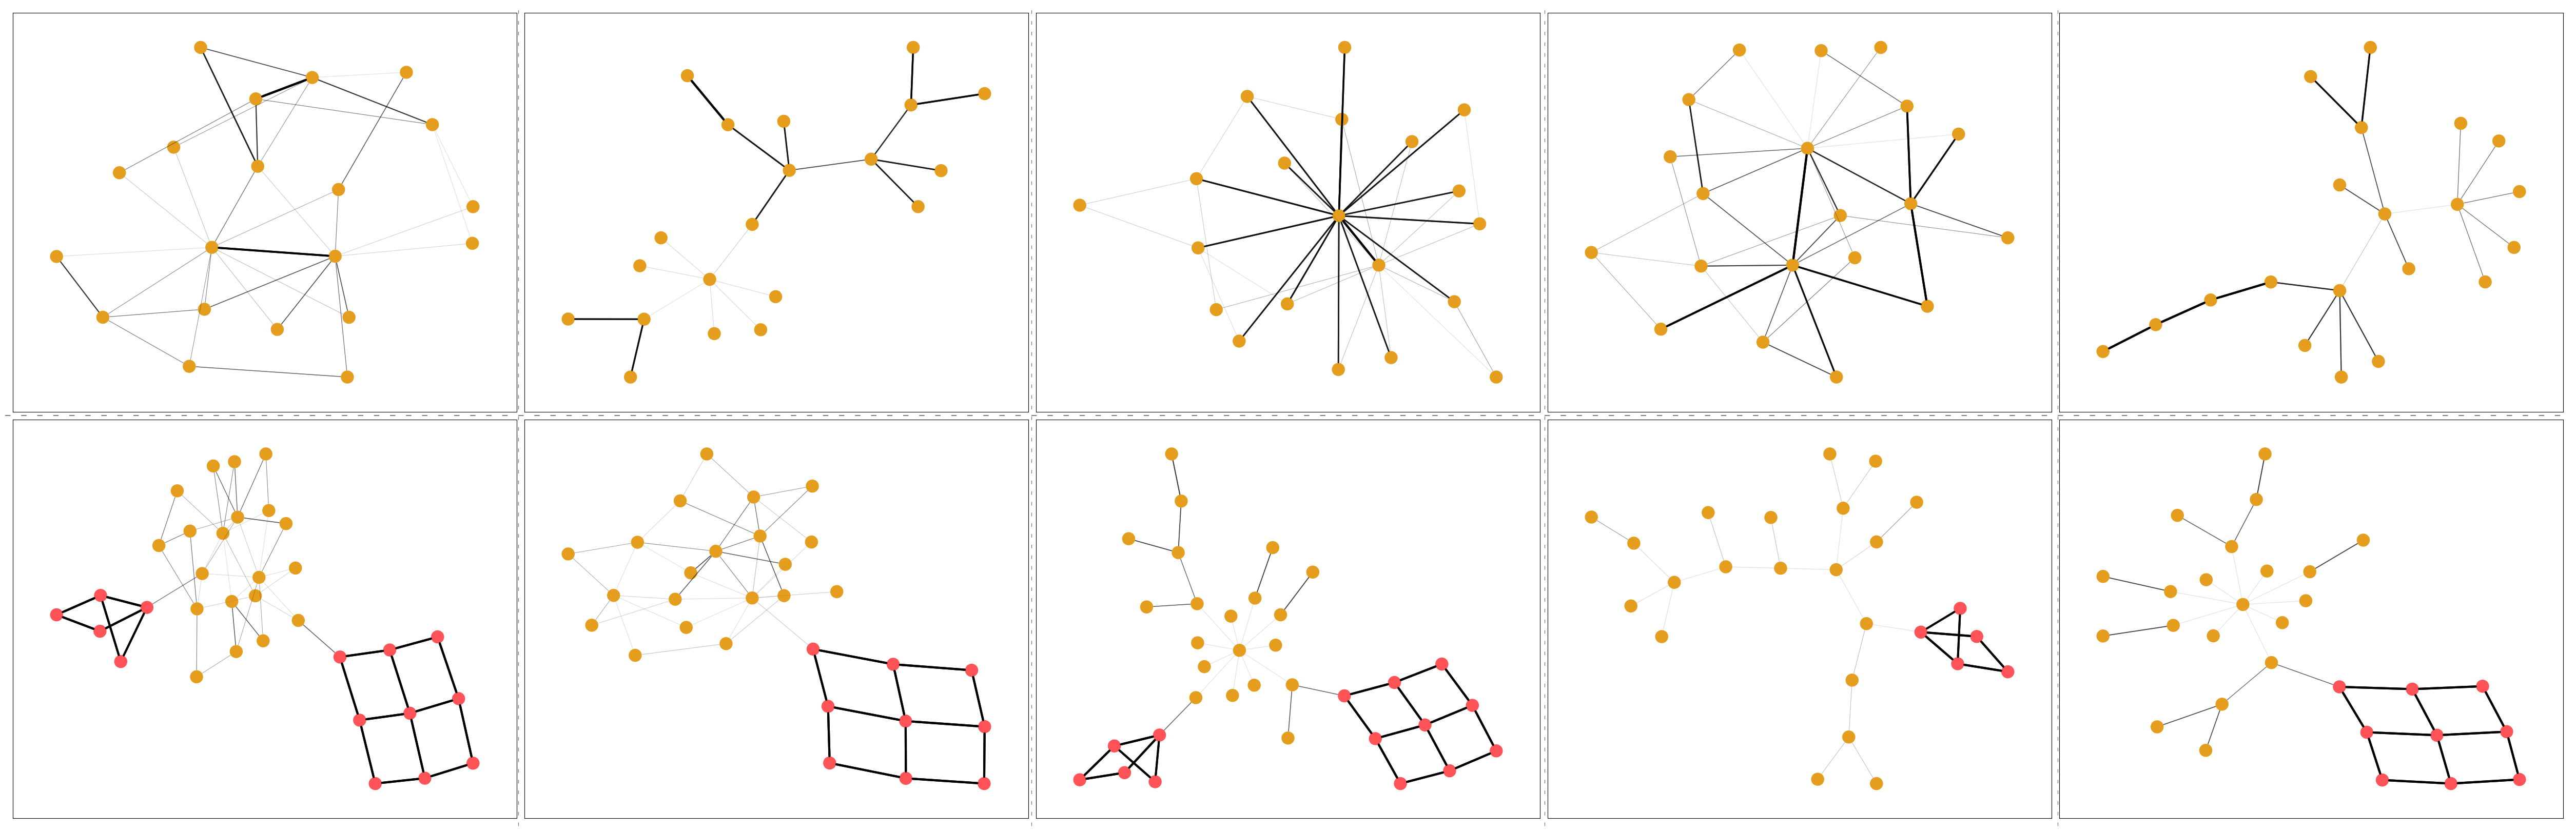

In [9]:
%matplotlib inline
visualize_results(baseline, all_viz_set, test_set, num_viz_samples, dataset_name, None, method_name)
#gsat, all_viz_set, test_set, num_viz_samples, dataset_name, optimizer, method_name